<a href="https://colab.research.google.com/github/PiasTanmoy/Hate-Speech-Detection-BERT-and-CNN/blob/main/Hate_Speech_Detection_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?resource=download

In [ ]:
# https://www.kaggle.com/code/jatingoyal123/hate-offensive-language

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 4.9 MB 7.6 MB/s 
     |████████████████████████████████| 462 kB 56.4 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 9.3 MB/s 
     |████████████████████████████████| 99 kB 4.7 MB/s 
     |████████████████████████████████| 636 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 90 kB 7.5 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 47.8 MB 46 kB/s 
     |████████████████████████████████| 352 kB 46.7 MB/s 
     |████████████████████████████████| 237 kB 38.5 MB/s 
     |████████████████████████████████| 1.2 MB 46.8 MB/s 


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 880 kB 65.3 MB/s 
     |████████████████████████████████| 6.6 MB 29.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=dfb1683b905e326da1164930a87a4bae7d2b95990308bbed2444d0bdfc8dd40a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *
from matplotlib.pyplot import figure



np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.8.0


# Dataset


Reading the dataset. This Hate Speech from Twitter dataset is collected from Kaggle

In [12]:
#df0 = pd.read_csv('/content/drive/Shareddrives/Hate Speech Recognition/Dataset/labeled_data.csv')
df0 = pd.read_csv('/content/drive/Shareddrives/Shared Dataset/Hate-Speech-Twitter/labeled_data.csv')
df0

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [13]:
#Doing some adjustments

c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [14]:
# Grouping data by label
df.groupby('label').count()

,text,category
label,,
0,1430,1430
1,19190,19190
2,4163,4163


In [15]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Offensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))


Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Offensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



In [16]:
from sklearn.model_selection import train_test_split

X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.20,
    random_state=42,
    stratify=df.label.values,    
)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.20,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [18]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [19]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         286
                         train        915
                         val          229
neither            2     test         833
                         train       2664
                         val          666
offensive_language 1     test        3838
                         train      12281
                         val         3071

In [19]:
df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1,train
24779,"you've gone and broke the wrong heart baby, an...",neither,2,train
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1,train
24781,youu got wild bitches tellin you lies,offensive_language,1,train


In [ ]:
df_saved = df

In [ ]:
df = df_saved

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


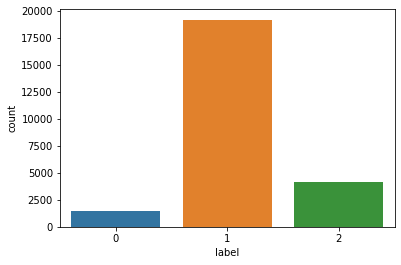

In [ ]:
import seaborn as sns
sns.countplot('label',data=df_saved)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


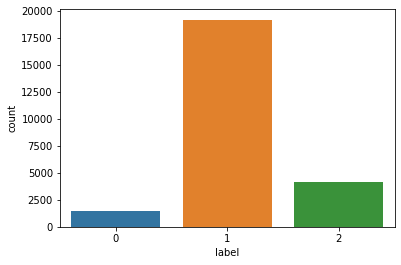

In [ ]:
import seaborn as sns
sns.countplot('label',data=df)

# Oversampling

In [ ]:
df_0  = df[df['label'] == 0]
df = df.append([df_0]*15,ignore_index=True)

df_2  = df[df['label'] == 2]
df = df.append([df_2]*5,ignore_index=True)

df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
67043,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...,neither,2,train
67044,yea so about @N_tel 's new friend.. all my fri...,neither,2,val
67045,"you know what they say, the early bird gets th...",neither,2,test
67046,"you've gone and broke the wrong heart baby, an...",neither,2,train


In [ ]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test        4576
                         train      14640
                         val         3664
neither            2     test        4998
                         train      15984
                         val         3996
offensive_language 1     test        3838
                         train      12281
                         val         3071

In [ ]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Offensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 67048
    hate: 22880 (34.12% of total)

Examples:
    Total: 67048
    Offensive: 19190 (28.62% of total)

Examples:
    Total: 67048
    Neither: 24978 (37.25% of total)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


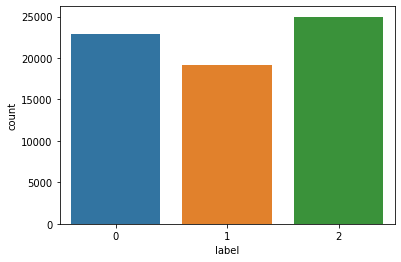

In [ ]:
import seaborn as sns
sns.countplot('label',data=df)

In [20]:
df_train = df.loc[df["data_type"]=="train"]
df_train

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",offensive_language,1,train
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1,train
24779,"you've gone and broke the wrong heart baby, an...",neither,2,train
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1,train
24781,youu got wild bitches tellin you lies,offensive_language,1,train


In [21]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,category,label,data_type
9,""" @rhythmixx_ :hobbies include: fighting Maria...",offensive_language,1,val
11,""" Murda Gang bitch its Gang Land """,offensive_language,1,val
15,""" bitch nigga miss me with it """,offensive_language,1,val
40,""" momma said no pussy cats inside my doghouse """,neither,2,val
43,""" pimps up pimps up hoes down "" Future voice",offensive_language,1,val


In [22]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
12,""" So hoes that smoke are losers ? "" yea ... go...",offensive_language,1,test
14,""" bitch get up off me """,offensive_language,1,test
17,""" bitch who do you love """,offensive_language,1,test
25,""" her pussy lips like Heaven doors "" &#128524;",offensive_language,1,test


In [23]:
df_train.shape, df_val.shape, df_test.shape

((15860, 4), (3966, 4), (4957, 4))

In [ ]:
df.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

<class 'set'>


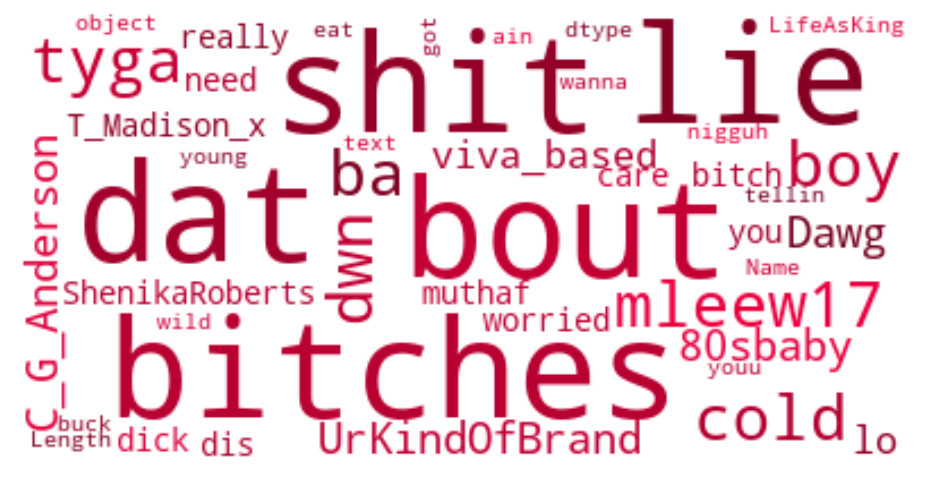

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.dpi"] = 120

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="offensive_language"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

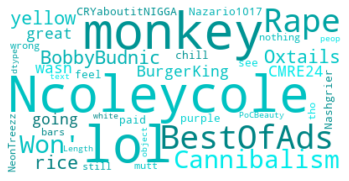

In [ ]:

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="neither"][200:700].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

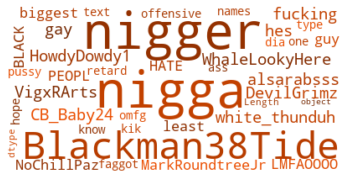

In [ ]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="hate_speech"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [25]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)

In [26]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'@realbigasian wtf mine was just a fried Twinkie w powdered sugar I got hoed'
 b"If i wasn't a Yankee fan i probably would be a SF Giants fan LOL"
 b"&#8220;@waymoflydenu If you do tax fraud you bet not dare tweet about voting bitch&#8221;all of them tweeting they don't do politics"
 b'For such bold people confrontation seems to make bitches out of alot of you'
 b'Only basic bitches workout at planet fitness' b'@daniellesayswha hoe'
 b'RT @LynchieWCVB: Big night at WCVB. Martha Coakley-Charlie Baker debate here at 7, Bruins-Minnesota WIld, World Series Game #6.'
 b"You can ask if I fucked a bitch but can't ask how my Father's Day was?!! ... These hoes be outta line!"
 b'&#128553;&#128514; RT @willieBEAMINN: @_VinChi3 bitches they get bat or sumn *ak voice*'
 b"Sorry fo da rant. It make me mad and ashamed to be colored. I wish I be white so y'all would like me"
 b'RT @TwitchyTeam: Low turnout reported, but Charlie Crist just filed and emergency motion to extend voting hours 

# BERT

In [6]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}



# RUN

In [7]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [27]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'Lmaoo &#8220;@LeanandCuisine: Bad bitch: Can I hit that?\n\n"You matching or.....?"\n\nBad bitch: *bats eyelashes*\n\n".........are you matching or?"&#8221;'
Label : 1
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1048  2863  9541  1004  1001  6445 11387  1025  1030  8155  5685]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [29]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.65045017  0.7966329  -0.16158627  0.4575414   0.5530617   0.74427235
  0.98251706 -0.98554176 -0.0041358  -0.9979813  -0.23572691 -0.3324595 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.4164694   0.5572508   0.08427519 ...  0.48982596  0.1511397
   0.5042689 ]
 [-0.48415112  0.93620783 -0.49271443 ... -0.05023898  0.48836547
  -0.91414315]
 [-0.31254748 -0.28849804  0.6214676  ...  0.63881046 -0.06970721
  -0.14143786]
 ...
 [ 0.30515522  0.4299883   0.36195913 ... -0.20450404  0.16840969
   0.08513639]
 [ 0.57598776  0.4359399   0.2879573  ...  1.2538764   0.3162577
  -0.15511072]
 [ 0.36972338  0.15289626 -1.136932   ... -0.29544467  0.27597833
  -0.89287317]]


In [30]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [31]:
#initial_output_bias = np.array([3.938462, 6.535164, 5.])
#initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias = np.array([2, 15, 5.])
initial_output_bias 

array([ 2., 15.,  5.])

In [32]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.3)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [33]:
def build_classifier_model2(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(1024, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1024, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1024, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.5)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

With Bias Model 1

In [ ]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50000054 0.7310475  0.5000135 ]], shape=(1, 3), dtype=float32)


Without output bias Model 1

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5375586  0.5385838  0.66704255]], shape=(1, 3), dtype=float32)


Without Bias Model 2

In [ ]:
classifier_model = build_classifier_model2()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.55959666 0.59364986 0.5942108 ]], shape=(1, 3), dtype=float32)


With Bias Model 2

In [34]:
classifier_model = build_classifier_model2(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5000007 0.7310502 0.5000099]], shape=(1, 3), dtype=float32)


In [ ]:
classifier_model.get_weights()[-1]

array([ 2., 15.,  5.], dtype=float32)

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [35]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#metrics = tf.metrics.Accuracy()

In [36]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [37]:
#  classifier_model.compile(optimizer=optimizer,
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

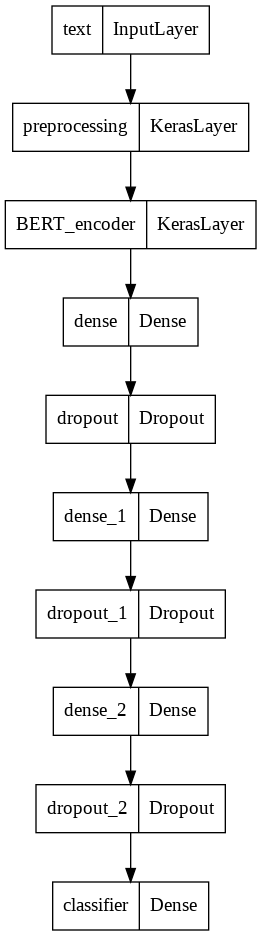

In [41]:
tf.keras.utils.plot_model(classifier_model)

In [39]:
classifier_model.save("BERT.h5")

# Train History

Train 1 (drop out=0.2)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


628/628 [==============================] - 138s 207ms/step - loss: 2.1527 - accuracy: 0.7192 - val_loss: 0.4596 - val_accuracy: 0.8265
Epoch 2/10
628/628 [==============================] - 132s 211ms/step - loss: 0.5647 - accuracy: 0.8333 - val_loss: 0.4619 - val_accuracy: 0.8153
Epoch 3/10
628/628 [==============================] - 133s 212ms/step - loss: 0.4585 - accuracy: 0.8625 - val_loss: 0.3772 - val_accuracy: 0.8400
Epoch 4/10
628/628 [==============================] - 134s 213ms/step - loss: 0.3776 - accuracy: 0.8856 - val_loss: 0.3994 - val_accuracy: 0.8512
Epoch 5/10
628/628 [==============================] - 135s 214ms/step - loss: 0.3099 - accuracy: 0.9039 - val_loss: 0.3034 - val_accuracy: 0.9072
Epoch 6/10
628/628 [==============================] - 134s 213ms/step - loss: 0.2655 - accuracy: 0.9315 - val_loss: 0.4188 - val_accuracy: 0.8736
Epoch 7/10
628/628 [==============================] - 134s 213ms/step - loss: 0.2082 - accuracy: 0.9438 - val_loss: 0.3803 - val_accura

Train 2 (drop out = 0.3)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


628/628 [==============================] - 137s 209ms/step - loss: 2.1629 - accuracy: 0.7223 - val_loss: 0.5775 - val_accuracy: 0.7831
Epoch 2/10
628/628 [==============================] - 133s 212ms/step - loss: 0.6072 - accuracy: 0.8297 - val_loss: 0.3913 - val_accuracy: 0.8610
Epoch 3/10
628/628 [==============================] - 134s 213ms/step - loss: 0.4959 - accuracy: 0.8620 - val_loss: 0.2891 - val_accuracy: 0.9077
Epoch 4/10
628/628 [==============================] - 134s 214ms/step - loss: 0.4292 - accuracy: 0.8823 - val_loss: 0.3183 - val_accuracy: 0.9018
Epoch 5/10
628/628 [==============================] - 134s 214ms/step - loss: 0.3535 - accuracy: 0.9050 - val_loss: 0.4448 - val_accuracy: 0.8557
Epoch 6/10
628/628 [==============================] - 134s 214ms/step - loss: 0.2866 - accuracy: 0.9210 - val_loss: 0.3786 - val_accuracy: 0.8879
Epoch 7/10
628/628 [==============================] - 134s 214ms/step - loss: 0.2384 - accuracy: 0.9365 - val_loss: 0.4091 - val_accura

Train 3 [Oversampling]

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1697/1697 [==============================] - 362s 210ms/step - loss: 1.0904 - accuracy: 0.6543 - val_loss: 0.6819 - val_accuracy: 0.8340
Epoch 2/10
1697/1697 [==============================] - 362s 213ms/step - loss: 0.2376 - accuracy: 0.9224 - val_loss: 0.9812 - val_accuracy: 0.8318
Epoch 3/10
1697/1697 [==============================] - 361s 213ms/step - loss: 0.1098 - accuracy: 0.9663 - val_loss: 1.5385 - val_accuracy: 0.8050
Epoch 4/10
1697/1697 [==============================] - 361s 213ms/step - loss: 0.0725 - accuracy: 0.9798 - val_loss: 1.7076 - val_accuracy: 0.8103
Epoch 5/10
1697/1697 [==============================] - 361s 212ms/step - loss: 0.0510 - accuracy: 0.9874 - val_loss: 2.5685 - val_accuracy: 0.7360
Epoch 6/10
1697/1697 [==============================] - 362s 213ms/step - loss: 0.0286 - accuracy: 0.9926 - val_loss: 2.6286 - val_accuracy: 0.7451
Epoch 7/10
1311/1697 [======================>.......] - ETA: 1:18 - loss: 0.0217 - accuracy: 0.9949

KeyboardInterrupt: ignored

Train 4

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 258s 187ms/step - loss: 0.9351 - accuracy: 0.7152 - val_loss: 0.7570 - val_accuracy: 0.8275
Epoch 2/5
1341/1341 [==============================] - 247s 184ms/step - loss: 0.1917 - accuracy: 0.9385 - val_loss: 1.2209 - val_accuracy: 0.7993
Epoch 3/5
1341/1341 [==============================] - 247s 184ms/step - loss: 0.0978 - accuracy: 0.9704 - val_loss: 1.5470 - val_accuracy: 0.7747
Epoch 4/5
1341/1341 [==============================] - 251s 187ms/step - loss: 0.0611 - accuracy: 0.9831 - val_loss: 1.9273 - val_accuracy: 0.7539
Epoch 5/5
1341/1341 [==============================] - 246s 184ms/step - loss: 0.0411 - accuracy: 0.9887 - val_loss: 1.9597 - val_accuracy: 0.7633


Train 5

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 333s 243ms/step - loss: 1.2491 - accuracy: 0.6250 - val_loss: 0.8319 - val_accuracy: 0.8012
Epoch 2/5
1341/1341 [==============================] - 337s 252ms/step - loss: 0.2274 - accuracy: 0.9309 - val_loss: 1.0895 - val_accuracy: 0.8166
Epoch 3/5
1341/1341 [==============================] - 340s 253ms/step - loss: 0.1252 - accuracy: 0.9671 - val_loss: 1.6177 - val_accuracy: 0.7972
Epoch 4/5
1341/1341 [==============================] - 337s 251ms/step - loss: 0.0785 - accuracy: 0.9807 - val_loss: 2.1687 - val_accuracy: 0.7741
Epoch 5/5
1341/1341 [==============================] - 335s 250ms/step - loss: 0.0593 - accuracy: 0.9855 - val_loss: 2.3100 - val_accuracy: 0.7714


Train 6

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 347s 254ms/step - loss: 1.0240 - accuracy: 0.6884 - val_loss: 0.8334 - val_accuracy: 0.8260
Epoch 2/2
1341/1341 [==============================] - 344s 256ms/step - loss: 0.1994 - accuracy: 0.9312 - val_loss: 1.0163 - val_accuracy: 0.8154


Run 1: Row 2: Without bias, class weights, raw dataset

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


496/496 [==============================] - 101s 188ms/step - loss: 0.5529 - accuracy: 0.7934 - val_loss: 0.3315 - val_accuracy: 0.8944
Epoch 2/2
496/496 [==============================] - 91s 183ms/step - loss: 0.3182 - accuracy: 0.9008 - val_loss: 0.2896 - val_accuracy: 0.9054


Run 2: 

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
496/496 [==============================] - 92s 185ms/step - loss: 0.6109 - accuracy: 0.8214 - val_loss: 0.4148 - val_accuracy: 0.8333
Epoch 2/2
496/496 [==============================] - 91s 184ms/step - loss: 0.6091 - accuracy: 0.8221 - val_loss: 0.4148 - val_accuracy: 0.8333


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


496/496 [==============================] - 132s 242ms/step - loss: 2.2107 - accuracy: 0.6510 - val_loss: 0.3774 - val_accuracy: 0.8636
Epoch 2/2
496/496 [==============================] - 120s 241ms/step - loss: 0.8259 - accuracy: 0.8003 - val_loss: 0.3744 - val_accuracy: 0.8583


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
496/496 [==============================] - 119s 240ms/step - loss: 0.7225 - accuracy: 0.8088 - val_loss: 0.3744 - val_accuracy: 0.8583
Epoch 2/2
496/496 [==============================] - 126s 254ms/step - loss: 0.7078 - accuracy: 0.8053 - val_loss: 0.3744 - val_accuracy: 0.8583


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


496/496 [==============================] - 126s 243ms/step - loss: 0.7546 - accuracy: 0.8224 - val_loss: 0.4025 - val_accuracy: 0.8863
Epoch 2/2
496/496 [==============================] - 119s 240ms/step - loss: 0.3607 - accuracy: 0.8902 - val_loss: 0.4041 - val_accuracy: 0.8865


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 328s 243ms/step - loss: 0.2233 - accuracy: 0.9589 - val_loss: 0.9107 - val_accuracy: 0.8122
Epoch 2/2
1341/1341 [==============================] - 333s 248ms/step - loss: 0.2190 - accuracy: 0.9596 - val_loss: 0.9107 - val_accuracy: 0.8122


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 338s 244ms/step - loss: 3.5769 - accuracy: 0.6991 - val_loss: 0.8475 - val_accuracy: 0.8130
Epoch 2/2
1341/1341 [==============================] - 324s 241ms/step - loss: 0.2538 - accuracy: 0.9281 - val_loss: 1.0056 - val_accuracy: 0.8242


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 341s 248ms/step - loss: 1.2242 - accuracy: 0.7058 - val_loss: 0.8360 - val_accuracy: 0.7884
Epoch 2/2
1341/1341 [==============================] - 326s 243ms/step - loss: 0.2458 - accuracy: 0.9273 - val_loss: 1.0948 - val_accuracy: 0.7958


# Last Train

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 255s 185ms/step - loss: 0.5711 - accuracy: 0.7539 - val_loss: 0.7033 - val_accuracy: 0.8091
Epoch 2/2
1341/1341 [==============================] - 246s 183ms/step - loss: 0.1958 - accuracy: 0.9433 - val_loss: 0.9435 - val_accuracy: 0.8041


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1341/1341 [==============================] - 257s 184ms/step - loss: 0.5631 - accuracy: 0.7567 - val_loss: 0.6410 - val_accuracy: 0.8187
Epoch 2/2
1341/1341 [==============================] - 245s 183ms/step - loss: 0.1710 - accuracy: 0.9470 - val_loss: 1.0007 - val_accuracy: 0.8147


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


496/496 [==============================] - 101s 189ms/step - loss: 0.7953 - accuracy: 0.8227 - val_loss: 0.3829 - val_accuracy: 0.8954
Epoch 2/2
496/496 [==============================] - 91s 183ms/step - loss: 0.3530 - accuracy: 0.8963 - val_loss: 0.3416 - val_accuracy: 0.9017


In [ ]:
classifier_model.save("classifier_model_BERT_MLP_Epoch_10_ACC_90.h5")

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

155/155 [==============================] - 14s 91ms/step - loss: 0.3423 - accuracy: 0.9054
Loss: 0.3423389494419098
Accuracy: 0.9053863286972046


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


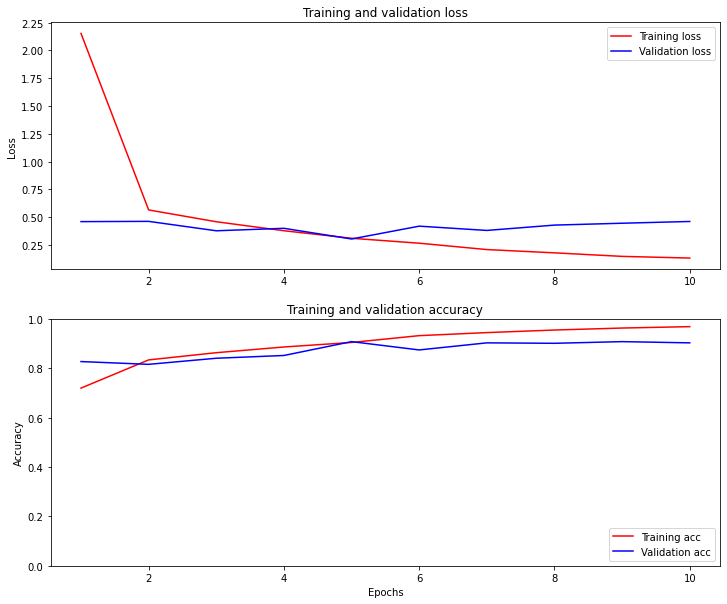

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1])

plt.savefig('Performance.png', dpi = 300)

In [ ]:
dataset_name = 'mpl_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
result =  classifier_model.predict(test_ds)
classes = np.argmax(result, axis=-1)

tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(classifier_model.predict(tweet))

from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)
y_test = np.array(list(chain.from_iterable(test_labels)))

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)
cf

array([[   0,  241,   45],
       [   0, 3751,   87],
       [   0,   96,  737]])

In [ ]:
def counts_from_confusion(confusion):
    """
    Obtain TP, FN FP, and TN for each class in the confusion matrix
    """

    counts_list = []

    # Iterate through classes and store the counts
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]

        fn_mask = np.zeros(confusion.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion, fn_mask))

        fp_mask = np.zeros(confusion.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion, tn_mask))

        counts_list.append({'Class': i,
                            'TP': tp,
                            'FN': fn,
                            'FP': fp})

    return counts_list

In [ ]:
counts_from_confusion(cf)

[{'Class': 0, 'FN': 286.0, 'FP': 0.0, 'TP': 0},
 {'Class': 1, 'FN': 87.0, 'FP': 337.0, 'TP': 3751},
 {'Class': 2, 'FN': 96.0, 'FP': 132.0, 'TP': 737}]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.92      0.98      0.95      3838
           2       0.85      0.88      0.87       833

    accuracy                           0.91      4957
   macro avg       0.59      0.62      0.60      4957
weighted avg       0.85      0.91      0.88      4957



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


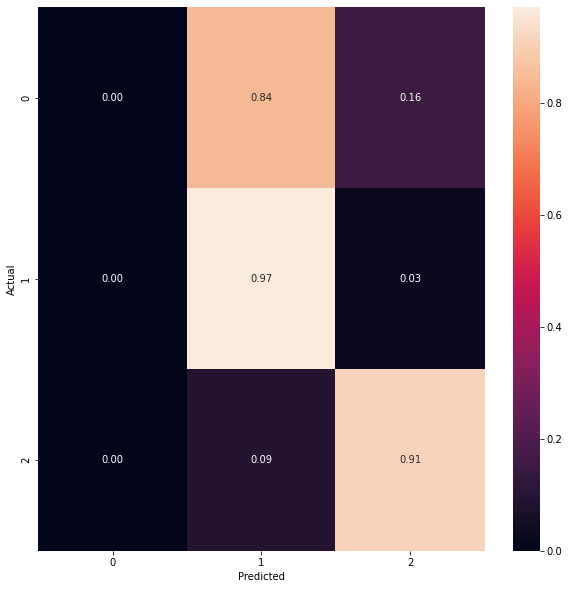

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precesion, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
precesion, recall, f1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.92136499, 0.82803943]),
 array([0.        , 0.97081813, 0.90756303]),
 array([0.        , 0.94544532, 0.86597938]))

In [ ]:
sum(precesion)/3.0, sum(recall)/3.0, sum(f1)/3.0, 

(0.5831348052040912, 0.6261270532183691, 0.6038082332967979)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='weighted'),

(array([0.        , 0.94544532, 0.86597938]),
 0.9041759128505145,
 0.6038082332967979,
 0.8775428599843086)